<h2> <class="myText"> Notebook links </h2>
<p> <class="myText"> <em> (Note, these links don't tend to work when you open the notebook in PyCharm, for example. Open the notebook in your browser to navigate the notebook using the links)</em> </p>

<p> 1. <a href="#data_preparation">Data preparation</a></p>
<p> 2. <a href="#validation_framework_setup">Setting up the validation framework</a></p>
<p> 3. <a href="#eda">Exploratory data analysis</a></p>
<ul>
    <li><a href="#feature_importance">Feature importance</a></li>
</ul>
<p> 4. <a href="#encoding">One-hot encoding</a></p>
<p> 5. <a href="#model_training">Model training</a></p>
<ul>
    <li><a href="#logistic_regression">Logistic Regression</a></li>
    <li><a href="#random_forest">Random Forest</a></li>
    <li><a href="#gradient_boosting (XGBoost)">Gradient Boosting</a></li>
</ul>
<p> 6. <a href="#model_selection">Selecting the final model</a></p>
<p> 7. <a href="#final_training">Train model on full training dataset</a></p>
<p> 8. <a href="#save_model">Save model</a></p>
<p> 9. <a href="#convert_notebook">Convert notebook to python script</a></p>

In [79]:
import contextlib
from IPython.display import display
import io
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df = (
    pl.scan_csv("./data/bank_customer_churn.csv").select(pl.all().exclude("RowNumber"))
).collect()

# Data preparation <a name = "data_preparation"></a>

In [3]:
# clean columns

# convert column names to lowercase
df.columns = [column.lower() for column in df.columns]

# rename columns to be more inline with python standards
df = df.rename(
    {
        "customerid": "customer_id",
        "creditscore": "credit_score",
        "numofproducts": "num_of_products",
        "hascrcard": "has_credit_card",
        "isactivemember": "is_active_member",
        "estimatedsalary": "estimated_salary",
        "exited": "churn",
    }
)

In [4]:
df.head()

customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,churn
i64,str,i64,str,str,i64,i64,f64,i64,i64,i64,f64,i64
15634602,"""Hargrave""",619,"""France""","""Female""",42,2,0.0,1,1,1,101348.88,1
15647311,"""Hill""",608,"""Spain""","""Female""",41,1,83807.86,1,0,1,112542.58,0
15619304,"""Onio""",502,"""France""","""Female""",42,8,159660.8,3,1,0,113931.57,1
15701354,"""Boni""",699,"""France""","""Female""",39,1,0.0,2,0,0,93826.63,0
15737888,"""Mitchell""",850,"""Spain""","""Female""",43,2,125510.82,1,1,1,79084.1,0


In [5]:
# check if the columns have been given the correct data type
df.schema

OrderedDict([('customer_id', Int64),
             ('surname', Utf8),
             ('credit_score', Int64),
             ('geography', Utf8),
             ('gender', Utf8),
             ('age', Int64),
             ('tenure', Int64),
             ('balance', Float64),
             ('num_of_products', Int64),
             ('has_credit_card', Int64),
             ('is_active_member', Int64),
             ('estimated_salary', Float64),
             ('churn', Int64)])

In [6]:
# check our dataframe and after the cleaning
df.head(10)

customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,churn
i64,str,i64,str,str,i64,i64,f64,i64,i64,i64,f64,i64
15634602,"""Hargrave""",619,"""France""","""Female""",42,2,0.0,1,1,1,101348.88,1
15647311,"""Hill""",608,"""Spain""","""Female""",41,1,83807.86,1,0,1,112542.58,0
15619304,"""Onio""",502,"""France""","""Female""",42,8,159660.8,3,1,0,113931.57,1
15701354,"""Boni""",699,"""France""","""Female""",39,1,0.0,2,0,0,93826.63,0
15737888,"""Mitchell""",850,"""Spain""","""Female""",43,2,125510.82,1,1,1,79084.1,0
15574012,"""Chu""",645,"""Spain""","""Male""",44,8,113755.78,2,1,0,149756.71,1
15592531,"""Bartlett""",822,"""France""","""Male""",50,7,0.0,2,1,1,10062.8,0
15656148,"""Obinna""",376,"""Germany""","""Female""",29,4,115046.74,4,1,0,119346.88,1
15792365,"""He""",501,"""France""","""Male""",44,4,142051.07,2,0,1,74940.5,0


# Setting up the validation framework <a name = "validation_framework_setup"></a>

In [7]:
df_full_train, df_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=11
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, shuffle=True, random_state=11
)

y_train = df_train.select("churn").to_pandas().values
y_val = df_val.select("churn").to_pandas().values
y_test = df_test.select("churn").to_pandas().values

df_train = df_train.drop("churn")
df_val = df_val.drop("churn")
df_test = df_test.drop("churn")

# Exploratory data analysis <a name = "eda"></a>

In [8]:
# check for nulls
df.null_count()

customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,churn
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# let's look at the distribution
churn_counts = df_full_train["churn"].value_counts()
churn_counts.with_columns(
    churn_rate=(pl.col("counts") / pl.col("counts").sum()).round(3)
)

churn,counts,churn_rate
i64,u32,f64
1,1639,0.205
0,6361,0.795


In [10]:
# // output:
# The % of users that are churning is 20.5%. This tells us we have a class imbalance.

In [11]:
# check min and max values, and compare them to the mean to see if there are any big outliers.
df_full_train.describe()

describe,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,churn
str,f64,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",8000.0,"""8000""",8000.0,"""8000""","""8000""",8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
"""null_count""",0.0,"""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.5691e7,null,650.663,null,null,38.861375,5.021,76450.777694,1.53125,0.70525,0.515125,99899.076943,0.204875
"""std""",71947.879928,null,97.310023,null,null,10.441505,2.881076,62332.055386,0.580358,0.455959,0.499802,57189.821447,0.403635
"""min""",1.5565701e7,"""Abazu""",350.0,"""France""","""Female""",18.0,0.0,0.0,1.0,0.0,0.0,11.58,0.0
"""25%""",1.5628219e7,null,583.0,null,null,32.0,3.0,0.0,1.0,0.0,0.0,51620.94,0.0
"""50%""",1.5691004e7,null,652.0,null,null,37.0,5.0,97092.87,1.0,1.0,1.0,99800.87,0.0
"""75%""",1.5752912e7,null,718.0,null,null,44.0,7.0,127642.44,2.0,1.0,1.0,148527.56,0.0
"""max""",1.581569e7,"""Zuyeva""",850.0,"""Spain""","""Male""",92.0,10.0,222267.63,4.0,1.0,1.0,199970.74,1.0


# Feature importance <a name = "feature_importance"></a>

### Categorical variables <a name = "categorical_variables"></a>
We'll use mutual score to measure the feature importance of our categorical variables

In [12]:
categorical = df_full_train.select(cs.string()).columns
# let's add is_active_member and has_credit_card in here because we removed them from the numerical list.
categorical.append("is_active_member")
categorical.append("has_credit_card")
categorical.remove("surname")

In [13]:
# check that all the necessary columns have been removed
df_full_train.select(categorical).head()

geography,gender,is_active_member,has_credit_card
str,str,i64,i64
"""Spain""","""Female""",0,1
"""Spain""","""Female""",1,1
"""Germany""","""Male""",0,1
"""Germany""","""Male""",1,1
"""France""","""Female""",0,0


In [14]:
global_churn_rate = df_full_train.select(pl.mean("churn")).item()

In [15]:
# let's first look at churn rate, diff and risk ratio.
# * note, it might be easier to just use mutual information but this will give us an idea first of the churn rate of each group compared to the global churn rate

for c in ["geography", "is_active_member", "gender", "has_credit_card"]:
    df_group = df_full_train.group_by(c).agg(
        mean=pl.mean("churn"), count=pl.count("churn")
    )
    df_group = df_group.with_columns(
        diff=df_group["mean"] - global_churn_rate,
        risk=df_group["mean"] / global_churn_rate,
    )
    display(df_group)

geography,mean,count,diff,risk
str,f64,u32,f64,f64
"""Germany""",0.330335,2001,0.12546,1.612373
"""Spain""",0.166246,1979,-0.038629,0.811449
"""France""",0.161443,4020,-0.043432,0.788006


is_active_member,mean,count,diff,risk
i64,f64,u32,f64,f64
0,0.268884,3879,0.064009,1.312428
1,0.144625,4121,-0.06025,0.705919


gender,mean,count,diff,risk
str,f64,u32,f64,f64
"""Male""",0.164531,4370,-0.040344,0.803079
"""Female""",0.253444,3630,0.048569,1.237064


has_credit_card,mean,count,diff,risk
i64,f64,u32,f64,f64
0,0.209924,2358,0.005049,1.024643
1,0.202765,5642,-0.00211,0.989701


In [16]:
# now let's use mutual information, which will instead give us one number for each group to measure the importance of our categorical variables


def calculate_mutual_info_score(series):
    return mutual_info_score(series, df_full_train["churn"])

In [17]:
df_pandas = df_full_train.to_pandas()
mi = df_pandas[categorical].apply(calculate_mutual_info_score)
mi.sort_values(ascending=False)

geography           0.014981
is_active_member    0.011933
gender              0.005993
has_credit_card     0.000033
dtype: float64

In [18]:
# // findings:
#   - churn rate for customers in Germany is 61% higher than the global churn rate
#   - churn rate for non-active customers is 31% higher than the global churn rate

### Numerical variables <a name = "numerical_variables"></a>
Let's create a correlation matrix to check how correlated each of our numerical values are to our target variable.

We will compute the correlation coefficient between every pair of features in the dataset.

In [19]:
numerical = df_full_train.select(cs.numeric()).columns
# remove is_active_member and has_credit_card because they are not actually numerical values, they are categorical values
numerical.remove("is_active_member")
numerical.remove("has_credit_card")
numerical.remove("customer_id")
numerical.remove("churn")

In [20]:
# check that all the necessary columns have been removed
df_full_train.select(numerical).head()

credit_score,age,tenure,balance,num_of_products,estimated_salary
i64,i64,i64,f64,i64,f64
628,39,8,107553.33,1,117523.41
736,28,2,0.0,2,117431.1
545,53,5,114421.55,1,180598.28
768,48,3,122831.58,1,24533.89
489,38,5,117289.92,1,85231.88


In [21]:
# * I wasn't sure how to do this part in polars, so I converted the dataframe to a pandas df
df_pandas = df_full_train.to_pandas(use_pyarrow_extension_array=True)
# let's first check how each numerical feature correlates to our target variable
df_pandas[numerical].corrwith(df_pandas["churn"]).abs().sort_values(ascending=False)

age                 0.282247
balance             0.118784
num_of_products     0.058554
credit_score        0.017992
estimated_salary    0.015968
tenure              0.008645
dtype: float64

In [22]:
# // output: the top 2 highest correlation coefficient values are for age and balance. These values are low though, so we can say an increase in these values rarely results in an increase in churn.

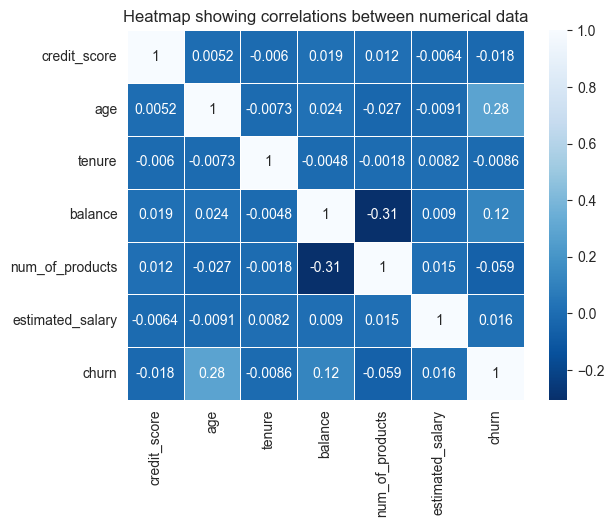

In [23]:
# we can visualise this in a heatmap by creating a correlation matrix between all the numerical features

sns.heatmap(
    df_full_train[numerical + ["churn"]].corr(),
    annot=True,
    linewidths=0.5,
    cmap="Blues_r",
    xticklabels=df_full_train[numerical + ["churn"]].columns,
    yticklabels=df_full_train[numerical + ["churn"]].columns,
)
plt.title("Heatmap showing correlations between numerical data")
plt.show()

/var/folders/gv/f1nkpk9n3_v8lsfhmxpd7d800000gp/T/ipykernel_5638/2873431363.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_pandas.hist(color="green", bins=80, ax=ax, layout=(3, 3), column=["credit_score", "age", "balance"])


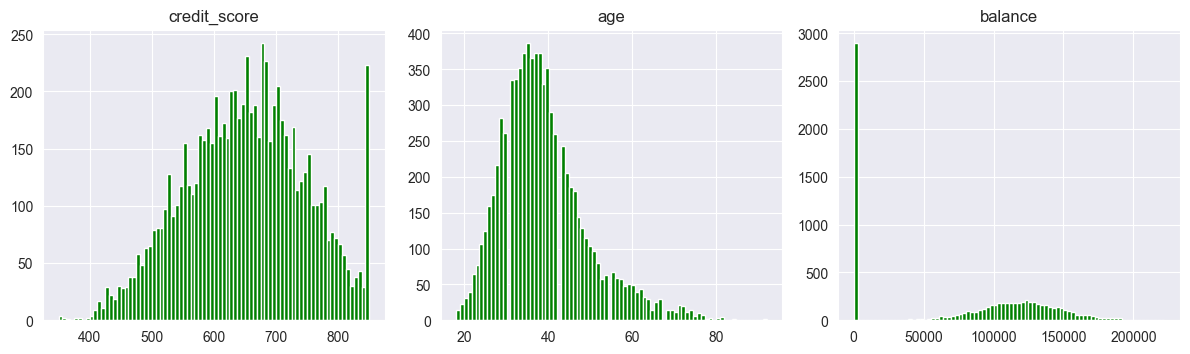

In [24]:
# let's plot some of these numerical values to see the distributions

fig = plt.figure(figsize=(12, 10))
ax = plt.gca()
df_pandas.hist(
    color="green",
    bins=80,
    ax=ax,
    layout=(3, 3),
    column=["credit_score", "age", "balance"],
)
plt.tight_layout()
plt.show()

In [25]:
# let's explore a bit deeper the feature with the highest correlation to our churn variable, which is age.
df_full_train["age"].value_counts().sort("age")

age,counts
i64,u32
18,15
19,22
20,31
21,40
22,65
23,77
24,106
25,124
26,159


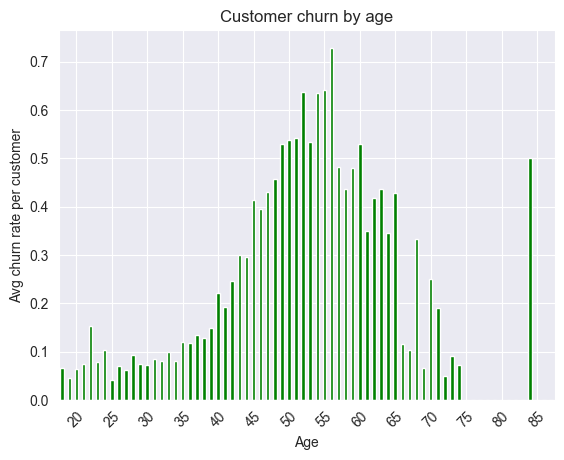

In [26]:
# plot the average churn rate for each age group

# group the data by age and calculate the mean churn for each age group
grouped = df_pandas.groupby("age")["churn"].mean()

grouped.plot(kind="bar", color="green")

plt.xlabel("Age")
plt.ylabel("Avg churn rate per customer")
plt.title("Customer churn by age")

# # reduce the number of labels on the x-axis by showing them in intervals
start_index = grouped.index.tolist().index(20)
plt.xticks(
    np.arange(start_index, len(grouped), step=5),
    grouped.index[start_index::5],
    rotation=45,
)

plt.show()

In [27]:
print(
    f"Churn rate when age is less than 50      -> {round(df_full_train.filter(pl.col('age') <= 49).select(pl.mean('churn')).item(), 2)}"
)
print(
    f"Churn rate when age is between 50 and 60 -> {round(df_full_train.filter((pl.col('age') > 49) & (pl.col('age') <= 60)).select(pl.mean('churn')).item(), 2)}"
)
print(
    f"Churn rate when age is above 60          -> {round(df_full_train.filter(pl.col('age') > 60).select(pl.mean('churn')).item(), 2)}"
)

Churn rate when age is less than 50      -> 0.16
Churn rate when age is between 50 and 60 -> 0.57
Churn rate when age is above 60          -> 0.23


In [28]:
# // output: the results above show a normal distribution, which shows a positive correlation (as age increases, the likelihood of churn also increases) until about approximately age 56, at which point the likelihood of churn starts to decrease again.

# One-hot encoding <a name = "encoding"></a>

In [29]:
df_train.select(categorical).head()

geography,gender,is_active_member,has_credit_card
str,str,i64,i64
"""Spain""","""Female""",1,1
"""Germany""","""Female""",0,1
"""Spain""","""Male""",1,0
"""France""","""Female""",1,0
"""France""","""Male""",1,0


In [30]:
dv = DictVectorizer(sparse=False)

In [31]:
# note, we have included numerical variables as well here, but the DictVectorizer is smart enough to recognise that
dicts_train = df_train.select(categorical + numerical).to_dicts()
X_train = dv.fit_transform(dicts_train)

In [32]:
dicts_val = df_val.select(categorical + numerical).to_dicts()
X_val = dv.fit_transform(dicts_val)

In [33]:
dicts_test = df_test.select(categorical + numerical).to_dicts()
X_test = dv.fit_transform(dicts_test)

# Model training <a name = "model_training"></a>

### Logistic Regression <a name = "logistic_regression"></a> 

In [34]:
# train the model

model = LogisticRegression(solver="liblinear", C=10, max_iter=1000, random_state=11)
model.fit(X_train, y_train.ravel())

LogisticRegression(C=10, max_iter=1000, random_state=11, solver='liblinear')

In [35]:
# use the model to predict churn on the validation dataset

y_pred = model.predict_proba(X_val)[:, 1]

In [36]:
# calculate the ROC score for the model

auc = roc_auc_score(y_val, y_pred)
round(auc, 2)

# *note, I did not use Scikit Learn's accuracy_score() function here, because accuracy is not a good measure for datasets with class imbalance

0.67

In [37]:
# // the performance of this model is not even close to Random Forest and XGBoost, therefore I haven't fine-tuned the parameters

### Random Forest <a name = "random_forest"></a>

In [38]:
# let's tune the max_depth parameter first

max_depth_values = [6, 10, 20, 30]

scores = []

for depth in max_depth_values:
    for num_estimators in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=num_estimators,
            max_depth=depth,
            random_state=11,
        )
        rf.fit(X_train, y_train.ravel())
        y_pred = rf.predict_proba(X_val)[0:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((depth, num_estimators, auc))

In [39]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pl.DataFrame(scores, schema=columns)
df_scores.sort("auc", descending=True).head()

max_depth,n_estimators,auc
i64,i64,f64
10,200,0.854908
10,170,0.854622
10,190,0.85442
10,180,0.85438
10,140,0.854272


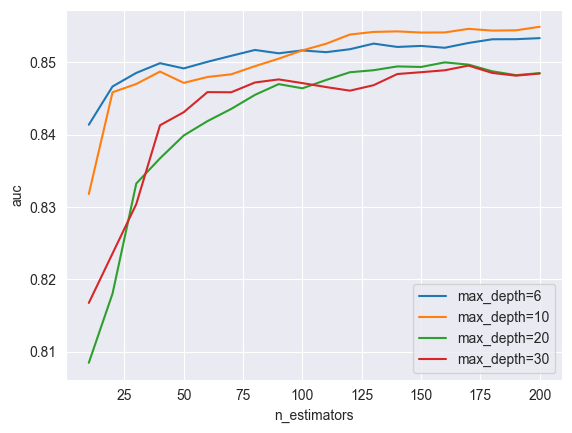

In [40]:
for depth in max_depth_values:
    df_subset = df_scores.filter(max_depth=depth)

    plt.plot(
        df_subset.select("n_estimators"),
        df_subset.select("auc"),
        label=f"max_depth={depth}",
    )
    plt.xlabel("n_estimators")
    plt.ylabel("auc")
    # plt.vlines(50, 0.783, 0.817, color="grey", linestyles="--", alpha=0.5)

plt.legend()
plt.show()

In [41]:
# // result: best max_depth = 10

In [42]:
# next let's tune the min_samples_leaf parameter first

min_samples_leaf_values = [5, 6, 10, 20]

scores = []

for min_samples_leaf in min_samples_leaf_values:
    for num_estimators in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=num_estimators,
            max_depth=10,
            min_samples_leaf=min_samples_leaf,
            random_state=11,
        )
        rf.fit(X_train, y_train.ravel())
        y_pred = rf.predict_proba(X_val)[0:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((min_samples_leaf, num_estimators, auc))

In [43]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pl.DataFrame(scores, schema=columns)
df_scores.sort("auc", descending=True).head()

min_samples_leaf,n_estimators,auc
i64,i64,f64
6,150,0.858786
6,100,0.858673
6,120,0.858653
6,200,0.858581
6,90,0.858502


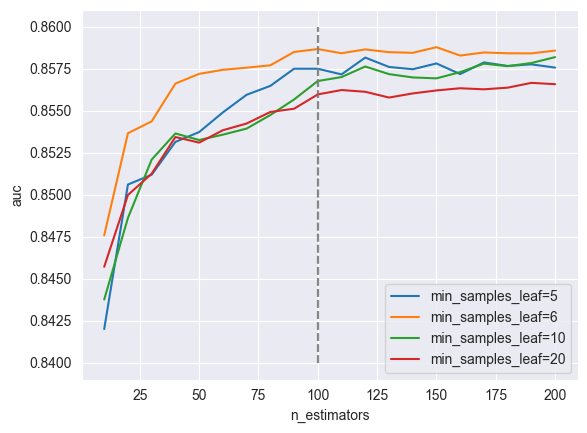

In [44]:
for min_samples_leaf in min_samples_leaf_values:
    df_subset = df_scores.filter(min_samples_leaf=min_samples_leaf)

    plt.plot(
        df_subset.select("n_estimators"),
        df_subset.select("auc"),
        label=f"min_samples_leaf={min_samples_leaf}",
    )
    plt.xlabel("n_estimators")
    plt.ylabel("auc")
    plt.vlines(100, 0.84, 0.86, color="grey", linestyles="--", alpha=0.5)

plt.legend()
plt.show()

In [45]:
# // result: best min_samples_leaf = 6

### Gradient Boosting (XGBoost) <a name = "gradient_boosting"></a>

In [46]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [47]:
def parse_xgb_output(output):
    results = []

    for line in output.strip().split("\n"):
        iteration_line, train_line, val_line = line.split("\t")

        iteration = int(iteration_line.strip("[]"))
        train_auc = float(train_line.split(":")[1])
        val_auc = float(val_line.split(":")[1])

        results.append((iteration, train_auc, val_auc))

    columns = ["num_iteration", "train_auc", "val_auc"]
    df_results = pl.DataFrame(results, schema=columns)

    return df_results

In [48]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [49]:
# first let's tune the eta parameter

eta_values = [0.4, 0.3, 0.1, 0.05, 0.01, 0.001]

scores = {}

for eta in eta_values:
    xgb_params = {
        "eta": eta,
        "max_depth": 6,
        "min_child_weight": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 8,
        "seed": 1,
        "verbosity": 1,
    }
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
        )
    output = f.getvalue()
    key = f"eta={eta}"
    scores[key] = parse_xgb_output(output)

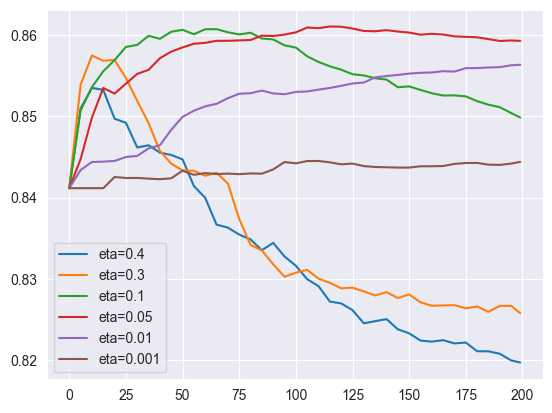

In [50]:
etas = ["eta=0.4", "eta=0.3", "eta=0.1", "eta=0.05", "eta=0.01", "eta=0.001"]
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.select("num_iteration"), df_score.select("val_auc"), label=eta)
plt.legend()
plt.show()

In [51]:
# // result: best eta = 0.05

In [52]:
# next let's tune the max_depth parameter

max_depth_values = [3, 4, 8, 10, 20, 30]

scores = {}

for max_depth in max_depth_values:
    xgb_params = {
        "eta": 0.05,
        "max_depth": max_depth,
        "min_child_weight": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 8,
        "seed": 1,
        "verbosity": 1,
    }
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
        )
    output = f.getvalue()
    key = f"max_depth={max_depth}"
    scores[key] = parse_xgb_output(output)

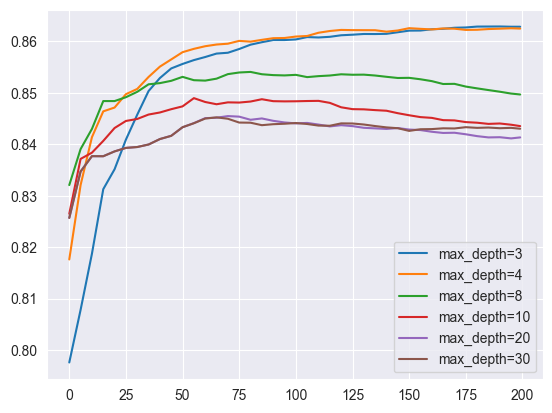

In [53]:
max_depths = [
    "max_depth=3",
    "max_depth=4",
    "max_depth=8",
    "max_depth=10",
    "max_depth=20",
    "max_depth=30",
]
for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(
        df_score.select("num_iteration"), df_score.select("val_auc"), label=max_depth
    )
plt.legend()
plt.show()

In [54]:
# // result: best max_depth = 4

In [55]:
# next let's tune the min_child_weight parameter

min_child_weight_values = [1, 5, 10, 12]

scores = {}

for min_child_weight in min_child_weight_values:
    xgb_params = {
        "eta": 0.05,
        "max_depth": 4,
        "min_child_weight": min_child_weight,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 8,
        "seed": 1,
        "verbosity": 1,
    }
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
        )
    output = f.getvalue()
    key = f"min_child_weight={min_child_weight}"
    scores[key] = parse_xgb_output(output)

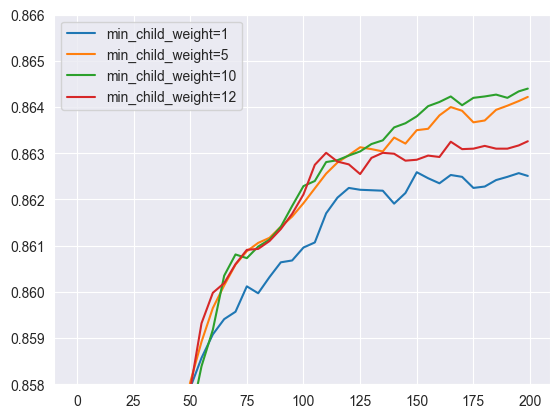

In [56]:
min_child_weights = [
    "min_child_weight=1",
    "min_child_weight=5",
    "min_child_weight=10",
    "min_child_weight=12",
]
for min_child_weight in min_child_weights:
    df_score = scores[min_child_weight]
    plt.plot(
        df_score.select("num_iteration"),
        df_score.select("val_auc"),
        label=min_child_weight,
    )
plt.ylim(0.858, 0.866)
plt.legend()
plt.show()

In [57]:
# // result: best min_child_weight = 10

In [58]:
# next let's tune the colsample_bytree parameter

colsample_bytree_values = [1, 0.7, 0.6, 0.5, 0.3]

scores = {}

for colsample_bytree in colsample_bytree_values:
    xgb_params = {
        "eta": 0.05,
        "max_depth": 4,
        "min_child_weight": 10,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 8,
        "seed": 1,
        "verbosity": 1,
    }
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
        )
    output = f.getvalue()
    key = f"colsample_bytree={colsample_bytree}"
    scores[key] = parse_xgb_output(output)

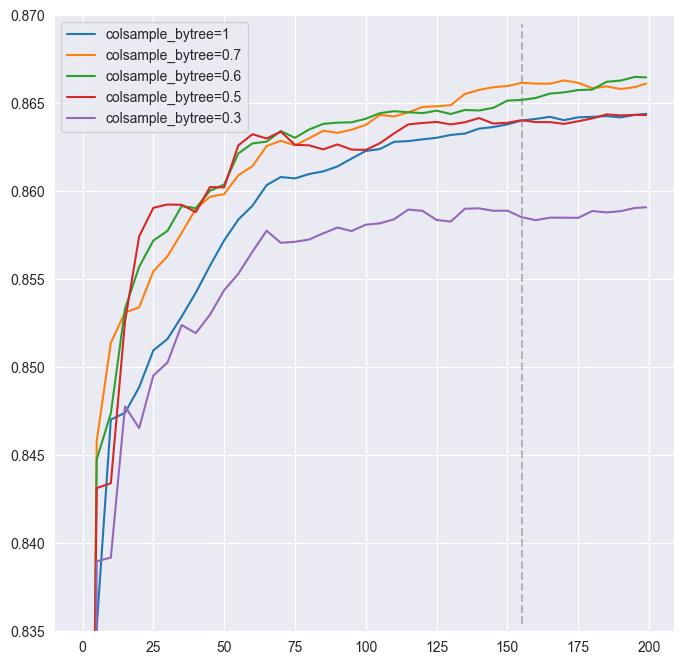

In [59]:
plt.figure(figsize=(8, 8))
colsample_bytrees = [
    "colsample_bytree=1",
    "colsample_bytree=0.7",
    "colsample_bytree=0.6",
    "colsample_bytree=0.5",
    "colsample_bytree=0.3",
]
for colsample_bytree in colsample_bytrees:
    df_score = scores[colsample_bytree]
    plt.plot(
        df_score.select("num_iteration"),
        df_score.select("val_auc"),
        label=colsample_bytree,
    )
plt.vlines(155, 0.8354, 0.8695, color="grey", linestyles="--", alpha=0.5)
plt.ylim(0.835, 0.87)
plt.legend()
plt.show()

In [60]:
# next let's try excluding some features that were not considered important from earlier in the notebook

full_feature_list = numerical + categorical

In [61]:
# small feature list 1

features_to_exclude_1 = [
    "has_credit_card",
    "credit_score",
    "estimated_salary",
    "tenure",
]

dv_2 = DictVectorizer(sparse=False)
feature_list_small_1 = [
    feature for feature in full_feature_list if feature not in features_to_exclude_1
]
dicts_train_small_1 = df_train.select(feature_list_small_1).to_dicts()
X_train_small_1 = dv_2.fit_transform(dicts_train_small_1)

dicts_val_small_1 = df_val.select(feature_list_small_1).to_dicts()
X_val_small_1 = dv_2.fit_transform(dicts_val_small_1)

features_small_1 = list(dv_2.get_feature_names_out())
dtrain_small_1 = xgb.DMatrix(
    X_train_small_1, label=y_train, feature_names=features_small_1
)
dval_small = xgb.DMatrix(X_val_small_1, label=y_val, feature_names=features_small_1)

watchlist_small_1 = [(dtrain_small_1, "train"), (dval_small, "val")]

In [62]:
# small feature list 2

features_to_exclude_2 = [
    "gender",
    "has_credit_card",
    "credit_score",
    "estimated_salary",
    "tenure",
]

dv_3 = DictVectorizer(sparse=False)
feature_list_small_2 = [
    feature for feature in full_feature_list if feature not in features_to_exclude_2
]
dicts_train_small_2 = df_train.select(feature_list_small_2).to_dicts()
X_train_small_2 = dv_3.fit_transform(dicts_train_small_2)

dicts_val_small_2 = df_val.select(feature_list_small_2).to_dicts()
X_val_small_2 = dv_3.fit_transform(dicts_val_small_2)

features_small_2 = list(dv_3.get_feature_names_out())
dtrain_small_2 = xgb.DMatrix(
    X_train_small_2, label=y_train, feature_names=features_small_2
)
dval_small = xgb.DMatrix(X_val_small_2, label=y_val, feature_names=features_small_2)

watchlist_small_2 = [(dtrain_small_2, "train"), (dval_small, "val")]

In [63]:
# small feature list 3

features_to_exclude_3 = ["gender", "has_credit_card", "estimated_salary", "tenure"]

dv_4 = DictVectorizer(sparse=False)
feature_list_small_3 = [
    feature for feature in full_feature_list if feature not in features_to_exclude_3
]
dicts_train_small_3 = df_train.select(feature_list_small_3).to_dicts()
X_train_small_3 = dv_3.fit_transform(dicts_train_small_3)

dicts_val_small_3 = df_val.select(feature_list_small_3).to_dicts()
X_val_small_3 = dv_3.fit_transform(dicts_val_small_3)

features_small_3 = list(dv_3.get_feature_names_out())
dtrain_small_3 = xgb.DMatrix(
    X_train_small_3, label=y_train, feature_names=features_small_3
)
dval_small = xgb.DMatrix(X_val_small_3, label=y_val, feature_names=features_small_3)

watchlist_small_3 = [(dtrain_small_3, "train"), (dval_small, "val")]

In [64]:
dtrain_dict = {
    "dtrain": {
        "matrix": dtrain,
        "watchlist": watchlist,
    },
    "dtrain_small_1": {
        "matrix": dtrain_small_1,
        "watchlist": watchlist_small_1,
    },
    "dtrain_small_2": {
        "matrix": dtrain_small_2,
        "watchlist": watchlist_small_2,
    },
    "dtrain_small_3": {
        "matrix": dtrain_small_3,
        "watchlist": watchlist_small_3,
    },
}

scores = {}

for name, attributes in dtrain_dict.items():
    xgb_params = {
        "eta": 0.05,
        "max_depth": 4,
        "min_child_weight": 10,
        "colsample_bytree": 0.7,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 8,
        "seed": 1,
        "verbosity": 1,
    }
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        xgb.train(
            xgb_params,
            attributes["matrix"],
            num_boost_round=155,
            verbose_eval=5,
            evals=attributes["watchlist"],
        )
    output = f.getvalue()
    key = f"{name}"
    scores[key] = parse_xgb_output(output)

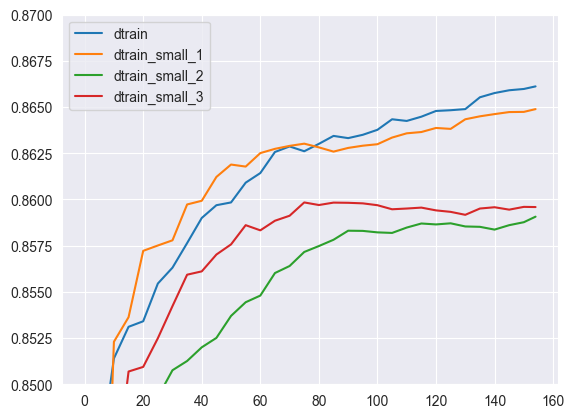

In [65]:
for name in dtrain_dict:
    df_score = scores[name]
    plt.plot(df_score.select("num_iteration"), df_score.select("val_auc"), label=name)
plt.ylim(0.85, 0.87)
plt.legend()
plt.show()

In [66]:
# // output: removing the features that were calculated to be least important didn't improve the accuracy, therefore we'll use all the features when we train the final model.

In [67]:
# # this nearly generated the best performing model, just 0.1 lower. This is much quicker though!
#
# from scipy.stats import uniform, randint # noqa: F401
# from sklearn.model_selection import RandomizedSearchCV # noqa: F401
#
# def report_best_scores(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")
#
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
#
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.05, 0.2), # default 0.1
#     "max_depth": randint(7, 10), # default 3
#     "n_estimators": randint(100, 140), # default 100
#     "subsample": uniform(0.6, 0.4)
# }
#
# # The optimization consumes a lot of computational resources
# # Run only once to find out optimal parameters
# RUN_OPTIMIZATION = True
#
# if RUN_OPTIMIZATION:
#     search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, verbose=1, n_jobs=1, return_train_score=True)
#     search.fit(X_train, y_train)
#     report_best_scores(search.cv_results_, 3)

# Selecting the final model <a name = "model_selection"></a>

In [68]:
# Logistic Regression
#
# accuracy -> 0.67

In [69]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=6,
    random_state=11,
)
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"accuracy -> {round(auc, 2)}")

accuracy -> 0.86


In [70]:
# XGBoost

xgb_params = {
    "eta": 0.05,
    "max_depth": 7,
    "min_child_weight": 10,
    "colsample_bytree": 0.8818305643167516,
    "gamma": 0.3971447249832312,
    "learning_rate": 0.07133985002268722,
    "subsample": 0.9731752268399818,
    "objective": "binary:logistic",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=155)

In [71]:
y_pred = model.predict(dval)
auc = roc_auc_score(y_val, y_pred)
print(f"accuracy -> {round(auc, 2)}")

accuracy -> 0.86


# Train model on full training dataset <a name = "final_training"></a>

In [72]:
# create a dataframe containing only the target variable
y_full_train = df_full_train.select("churn").to_pandas().values

# create feature matrix
dicts_full_train = df_full_train.select(categorical + numerical).to_dicts()
X_full_train = dv.transform(dicts_full_train)

In [73]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [74]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 4,
    "min_child_weight": 10,
    "colsample_bytree": 0.7,
    "objective": "binary:logistic",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=155)

In [75]:
y_pred = model.predict(dtest)
auc = roc_auc_score(y_test, y_pred)
print(f"accuracy -> {round(auc, 2)}")

accuracy -> 0.86


# Save model <a name = "save_model"></a>

In [76]:
# import pickle # noqa: F401

In [77]:
# output_file = "xgboost_model.bin"
# with open(output_file, "wb") as file_out:
#     pickle.dump((dv, model), file_out)

# Convert notebook to python script <a name = "convert_notebook"></a>

In [78]:
# !jupyter nbconvert development.ipynb --to script --no-prompt --output train